In [2]:
import numpy as np
import tensorflow as tf
import json, os, sys, math, time, random, joblib

In [3]:
# seq to seq model
data = json.load(open('data.json', 'r'))
data = np.array(data)

input_texts = data[:, 0]
target_texts = data[:, 1]

print(input_texts.shape, target_texts.shape)
[print(input_texts[i], target_texts[i].strip()) for i in range(10)];

(10000,) (10000,)
Go. Ve.
Go. Vete.
Go. Vaya.
Go. Váyase.
Hi. Hola.
Run! ¡Corre!
Run! ¡Corran!
Run! ¡Huye!
Run! ¡Corra!
Run! ¡Corred!


In [4]:
# vocab is sorted by frequency
input_corpus = [char for word in input_texts for char in word]
target_corpus = [char for word in target_texts for char in word]

input_vocab = ["<PAD>", "<UNK>", "<SOS>", "<EOS>", *sorted(set(input_corpus), key=input_corpus.count, reverse=True)]
target_vocab = ["<PAD>", "<SOS>", "<EOS>", *sorted(set(target_corpus), key=target_corpus.count, reverse=True)]

del input_corpus, target_corpus

input_vocab_size = len(input_vocab)
target_vocab_size = len(target_vocab)

char2idx_input = {char: idx for idx, char in enumerate(input_vocab)}
char2idx_target = {char: idx for idx, char in enumerate(target_vocab)}

In [5]:
input_vocab_size, target_vocab_size

(73, 85)

In [6]:
def vectorize(input_list: list[str]) -> list[list[int]]:
    return [[char2idx_input[c] if c in char2idx_input else char2idx_input["<UNK>"] for c in list(seq)] for seq in input_list]


def vectorize_target(input_list: list[str]) -> list[list[int]]:
    return [[char2idx_target[c] if c in char2idx_target else char2idx_target["<UNK>"] for c in list(seq)] for seq in input_list]

def decode(target_list: list[list[int]]) -> list[str]:
    return ["".join([target_vocab[c] for c in list(seq)]) for seq in target_list]

In [7]:
vectorize(["hello\\ world", " a a a a "]), decode([[0,1,2,3,4,5,6], [11]])

([[14, 5, 16, 16, 6, 1, 4, 23, 6, 13, 16, 17], [4, 9, 4, 9, 4, 9, 4, 9, 4]],
 ['<PAD><SOS><EOS> eoa', 't'])

In [8]:
EMBEDDING_DIM = 128
LSTM_UNITS = 128

def make_model():
    encoder_input = tf.keras.layers.Input(shape=(None,))
    encoder_embedded = tf.keras.layers.Embedding(input_vocab_size, EMBEDDING_DIM)(encoder_input)
    encoder_output, state_h, state_c = tf.keras.layers.LSTM(LSTM_UNITS, return_state=True)(encoder_embedded)
    encoder_state = [state_h, state_c]

    decoder_input = tf.keras.layers.Input(shape=(None,))
    decoder_embedded = tf.keras.layers.Embedding(target_vocab_size, EMBEDDING_DIM)(decoder_input)
    decoder_lstm = tf.keras.layers.LSTM(LSTM_UNITS, return_sequences=True)
    decoder_output = decoder_lstm(decoder_embedded, initial_state=encoder_state)
    output = tf.keras.layers.Dense(target_vocab_size, activation="softmax")(decoder_output)

    train_model = tf.keras.models.Model([encoder_input, decoder_input], output)

    encoder_model = tf.keras.models.Model(encoder_input, encoder_state)
    decoder_model = tf.keras.models.Model([decoder_input] + encoder_state, [output] + encoder_state)


    return model

In [9]:
# def prepare_training_data():
#     EOS_token_input = input_vocab.index("<EOS>")
#     EOS_token_target = target_vocab.index("<EOS>")
#     SOS_token_target = target_vocab.index("<SOS>")
#     enc_input = [[*x, EOS_token_input] for x in vectorize(input_texts)]
#     dec_vec = [[SOS_token_target, *x, EOS_token_target] for x in vectorize_target(target_texts)]

#     # turn to ragged tensor
#     enc_input = tf.ragged.constant(enc_input, dtype=tf.int32)
#     # dec_vec = tf.ragged.constant(dec_vec, dtype=tf.int32)

#     # dec_input is [SOS, x0, x1, ..., xn]
#     # dec_target is [x0, x1, ..., xn, EOS]
#     dec_input = tf.ragged.constant([x[:-1] for x in dec_vec], dtype=tf.int32)
#     dec_target = tf.ragged.constant([x[1:] for x in dec_vec], dtype=tf.int32)

#     return [enc_input, dec_input], dec_target

In [10]:
pad_sequences = tf.keras.preprocessing.sequence.pad_sequences

def prepare_training_data():
    EOS_token_input = input_vocab.index("<EOS>")
    EOS_token_target = target_vocab.index("<EOS>")
    SOS_token_target = target_vocab.index("<SOS>")
    enc_input = [[*x, EOS_token_input] for x in vectorize(input_texts)]
    dec_vec = [[SOS_token_target, *x, EOS_token_target] for x in vectorize_target(target_texts)]

    longest_enc_seq = max([len(x) for x in enc_input])
    longest_dec_seq = max([len(x) for x in dec_vec])

    enc_input = pad_sequences(enc_input, maxlen=longest_enc_seq, padding='pre')
    dec_input = pad_sequences(dec_vec, maxlen=longest_dec_seq, padding='pre')

    dec_target = np.zeros_like(dec_input)
    dec_target[:, :-1] = dec_input[:, 1:]
    dec_target[:, -1] = 0
    

    return [enc_input, dec_input], dec_target

In [11]:
[X1, X2], y = prepare_training_data()

In [12]:
# ds = tf.data.Dataset.from_tensor_slices((X1, X2, y))
# ds = ds.shuffle(10000).batch(128, drop_remainder=True)

# # map so each batch is not ragged
# def fix_batch(*batch):
#     for rt in batch:
#         padded = rt.to_tensor(0)
#         rt = tf.reverse(padded, [-1])
#     x1, x2, y = batch
#     return [x1, x2], y

# ds = ds.map(fix_batch)

In [13]:
X1[1], X2[1], y[1]

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 41,  6,  7,  3]),
 array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  1, 48,  4, 11,  4,  8,  2]),
 array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  1, 48,  4, 11,  4,  8,  2,  0]))

In [14]:
# Split the data into training and testing sets
indices = tf.range(start=0, limit=tf.shape(y)[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices)

[X1, X2, y] = [tf.gather(params=params, indices=shuffled_indices) for params in [X1, X2, y]]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 128)    9344        ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 128)    10880       ['input_2[0][0]']                
                                                                                              

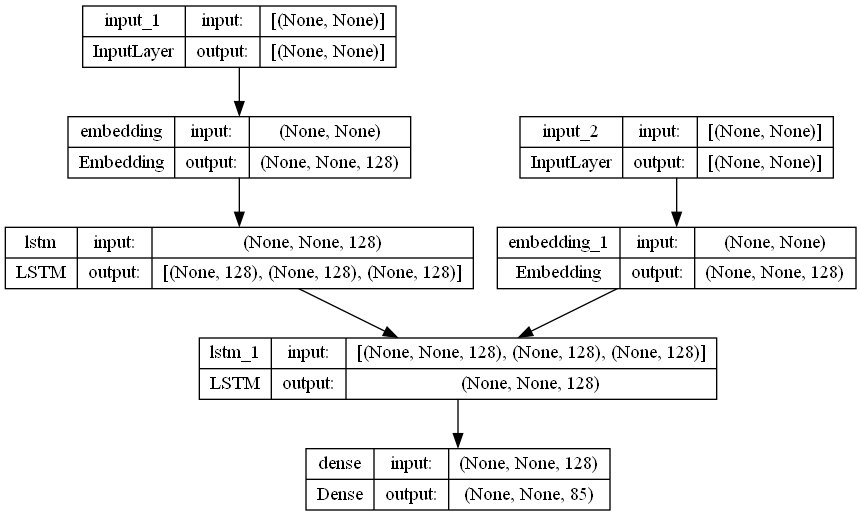

In [15]:
model = make_model()
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005), loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    [X1, X2],
    y,
    batch_size=128,
    epochs=20,
)
# Save model
model.save("tmp/s2s1")

Epoch 1/20
79/79 [==============================] - 4s 13ms/step - loss: 0.9606 - accuracy: 0.7282
Epoch 2/20
79/79 [==============================] - 1s 13ms/step - loss: 0.7482 - accuracy: 0.7718
Epoch 3/20
79/79 [==============================] - 1s 13ms/step - loss: 0.6763 - accuracy: 0.7910
Epoch 4/20
79/79 [==============================] - 1s 13ms/step - loss: 0.6309 - accuracy: 0.8042
Epoch 5/20
79/79 [==============================] - 1s 13ms/step - loss: 0.5982 - accuracy: 0.8140
Epoch 6/20
79/79 [==============================] - 1s 13ms/step - loss: 0.5717 - accuracy: 0.8219
Epoch 7/20
79/79 [==============================] - 1s 13ms/step - loss: 0.5507 - accuracy: 0.8281
Epoch 8/20
79/79 [==============================] - 1s 13ms/step - loss: 0.5326 - accuracy: 0.8332
Epoch 9/20
79/79 [==============================] - 1s 13ms/step - loss: 0.5178 - accuracy: 0.8380
Epoch 10/20
79/79 [==============================] - 1s 13ms/step - loss: 0.5047 - accuracy: 0.8416
Epoch 11/

INFO:tensorflow:Assets written to: tmp/s2s1\assets


INFO:tensorflow:Assets written to: tmp/s2s1\assets


In [ ]:
def translate(text):
    